In [1]:
import numpy as np
import time
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from skimage import restoration
from numpy.fft import fft2, ifft2, fftshift

import mtf as mtf_py
import hpo as hpo_py
import drizzle as drizzle_py
import ibp as ibp_py
from subpixel_edges import subpixel_edges

In [2]:
img = np.zeros((8, 8))

subpixel_edges(img, 15, 0, 2)
subpixel_edges(img, 15, 1, 2)
subpixel_edges(img, 15, 2, 2)

In [ ]:
def unsharp_mask(img, radius=1.5, amount=1.0):
    blurred = cv2.GaussianBlur(img, (0, 0), radius)
    sharp = cv2.addWeighted(img, 1 + amount, blurred, -amount, 0)
    return np.clip(sharp, 0, 255).astype(np.uint8)


def clahe(img, clip_limit=0.5):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    lab = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8,8))
    l = clahe.apply(l)
    
    temp = cv2.cvtColor(cv2.merge([l,a,b]), cv2.COLOR_LAB2RGB)
    return cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)

def apply_richardson_lucy(image, psf_size=5, iterations=30):
    print(f"PSF restoration (Richardson-Lucy, {iterations} iterations)")
    print("Processing...")
    
    img_float = image.astype(np.float32) / 255.0
    img_float = np.clip(img_float, 0, 1)
    
    psf = np.zeros((psf_size, psf_size))
    sigma = (psf_size - 1) / 4.0
    center = psf_size // 2
    for x in range(psf_size):
        for y in range(psf_size):
            dist = np.sqrt((x-center)**2 + (y-center)**2)
            psf[x, y] = np.exp(-(dist**2) / (2 * sigma**2))
    psf /= psf.sum()
    
    deconvolved = restoration.richardson_lucy(img_float, psf, num_iter=iterations, filter_epsilon=1e-6)
    return np.clip(deconvolved * 255, 0, 255).astype(np.uint8)

def wiener_deconvolution(img, psf_size, K):
    """
    img : blurred image (2D, float32)
    psf : point spread function
    K   : noise-to-signal ratio (e.g. 0.001–0.01)
    """
    img_float = img.astype(np.float32) / 255.

    # Gaussian psf
    sigma = (psf_size - 1) / 4.0
    ax = np.arange(-psf_size//2 + 1., psf_size//2 + 1.)
    xx, yy = np.meshgrid(ax, ax)
    psf = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    psf / psf.sum()
    
    
    # Pad PSF to image size
    psf_pad = np.zeros_like(img)
    ph, pw = psf.shape
    psf_pad[:ph, :pw] = psf
    psf_pad = fftshift(psf_pad)

    deconvolved = restoration.wiener(img_float, psf, balance=K)
    return np.clip(deconvolved * 255, 0, 255).astype(np.uint8)










def compute_mtf_at_nyquist(img, filename='test_LR800x800_v5_MTF', quantile_low=0.25, quantile_high=0.75, dpi=100, scale=1):
    start_time = time.time()
    
    # 1. Normalize input image
    img_normalized = (img - np.min(img)) / (np.max(img) - np.min(img))
    
    # 2. Set edge detection parameters
    edge_threshold = 1 / (25 * (np.quantile(img_normalized, quantile_high) - np.quantile(img_normalized, quantile_low)))
    
    # 3. Edge detection
    edges = subpixel_edges(img_normalized, edge_threshold, 1, 1)
    
    # 4. Obtain edge coordinate
    edges_xy = np.array([edges.x, edges.y]).T
    
    # 5. Visualize edges
    # plt.figure(figsize=(img_normalized.shape[1]/5., img_normalized.shape[0]/5.))
    # plt.imshow(img_normalized, cmap="gray", vmin=0., vmax=1.)
    # plt.axis('off')
    # plt.xticks([])
    # plt.yticks([])
    # plt.scatter(edges.x, edges.y, s=5, marker='.', c='red')
    # plt.tight_layout()
    # plt.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
    # plt.close()
    
    # 6. Calculate MTF
    MTF_at_Nyquist, MTF_50 = mtf_py.MTF.FigureMTF(
        img_normalized, 
        img_normalized, 
        edges_xy, 
        filename, 
        0, 0, 0, 
        scale,
        verbose=True
    )
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"MTF evaluation finished! Elapsed time: {elapsed_time:.2f} seconds")
    
    return MTF_at_Nyquist, MTF_50

In [4]:
LR1 = np.array(Image.open('../HPO dataset/IMGP0107.JPG'))[:, :, 0]
LR2 = np.array(Image.open('../HPO dataset/IMGP0108.JPG'))[:, :, 0]
LR3 = np.array(Image.open('../HPO dataset/IMGP0119.JPG'))[:, :, 0]
LR4 = np.array(Image.open('../HPO dataset/IMGP0130.JPG'))[:, :, 0]

LRs = [LR1, LR2, LR3, LR4]

h, w = LR1.shape

In [5]:
t1 = time.time()
s = ibp_py.calculate_shift(LRs[0], LRs, 'ecc')
print(time.time() - t1)
print(s)

Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.5250, y=-0.0205
Image 2 Shift: x=-0.0472, y=0.4826
Image 3 Shift: x=0.4709, y=0.1483
30.080899477005005
[[0.0, 0.0], [np.float32(0.52502793), np.float32(-0.020500865)], [np.float32(-0.047213323), np.float32(0.48255455)], [np.float32(0.47086227), np.float32(0.14833595)]]


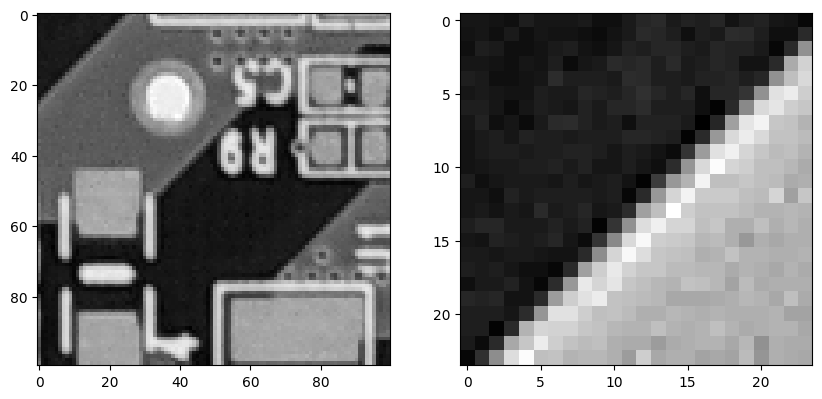

In [6]:
window_size = 24
x, y = 2380, 2486
lr = LR1[x:x+window_size, y:y+window_size]
lr_window = LR1[x:x+100, y:y+100]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(lr_window, cmap='gray')

ax2 = plt.subplot(1, 2, 2)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.imshow(lr, cmap='gray')

plt.show()

In [7]:
MTF_at_Nyquist_lr, MTF_50_lr = compute_mtf_at_nyquist(lr, filename = f'LR', dpi=100, scale=1)

if MTF_at_Nyquist_lr is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_lr)
    print("MTF_50:", MTF_50_lr)

MTF evaluation finished! Elapsed time: 2.06 seconds
MTF_at_Nyquist: 49.28371413221908
MTF_50: 0.494242345948806


0.01900339126586914


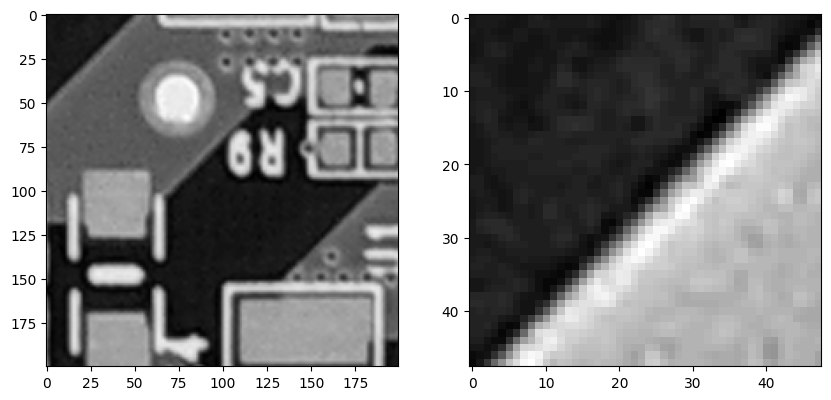

In [8]:
t1 = time.time()
SR_bicubic = cv2.resize(LR1, (w*2, h*2), interpolation=cv2.INTER_CUBIC)
# SR_bicubic = wiener_deconvolution(SR_bicubic, psf_size=3, K=0.001)
# SR_bicubic = apply_richardson_lucy(SR_bicubic, psf_size=5, iterations=30)
# SR_bicubic = clahe(SR_bicubic, clip_limit=0.5)
# SR_bicubic = unsharp_mask(SR_bicubic, radius=1.0, amount=1.2)
p_time = time.time() - t1
print(p_time)

sr_bicubic = SR_bicubic[x*2:(x+window_size)*2, y*2:(y+window_size)*2]
sr_bicubic_window = SR_bicubic[x*2:x*2+200, y*2:y*2+200]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_bicubic_window, cmap='gray')

ax2 = plt.subplot(1, 2, 2)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.imshow(sr_bicubic, cmap='gray')

plt.show()

In [9]:
MTF_at_Nyquist_sr_bicubic, MTF_50_sr_bicubic = compute_mtf_at_nyquist(sr_bicubic, filename = f'SR_BICUBIC', scale=2, dpi=100)

if MTF_at_Nyquist_sr_bicubic is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_bicubic)
    print("MTF_50:", MTF_50_sr_bicubic * 2)

MTF evaluation finished! Elapsed time: 1.13 seconds
MTF_at_Nyquist: 55.21359115185629
MTF_50: 0.54495859176316


0.2250196933746338


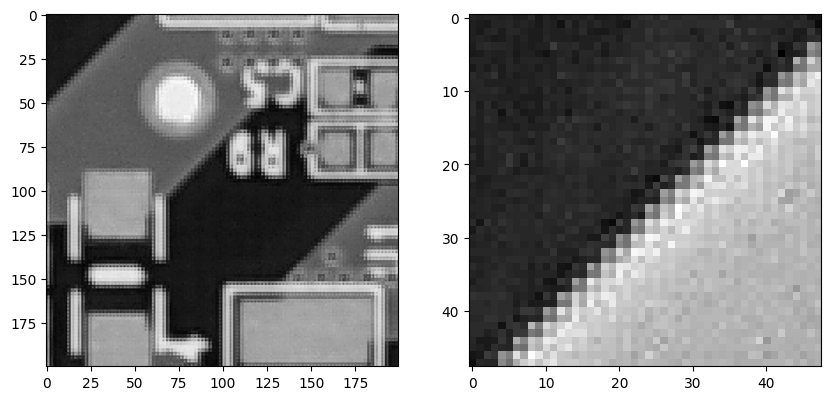

In [10]:
t1 = time.time()
SR_shuffle = hpo_py.HPO_shuffle(LRs)
# SR_shuffle = apply_richardson_lucy(SR_shuffle, psf_size=5, iterations=30)
# SR_shuffle = unsharp_mask(SR_shuffle, radius=1.0, amount=1.2)
p_time = time.time() - t1
print(p_time)

sr_shuffle = SR_shuffle[x*2:(x+window_size)*2, y*2:(y+window_size)*2]
sr_shuffle_window = SR_shuffle[x*2:x*2+200, y*2:y*2+200]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_shuffle_window, cmap='gray')

ax2 = plt.subplot(1, 2, 2)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.imshow(sr_shuffle, cmap='gray')

plt.show()

In [11]:
MTF_at_Nyquist_sr_shuffle, MTF_50_sr_shuffle = compute_mtf_at_nyquist(sr_shuffle, filename = f'SR_SHUFFLE', scale=2, dpi=100)

if MTF_at_Nyquist_sr_shuffle is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_shuffle)
    print("MTF_50:", MTF_50_sr_shuffle * 2)

MTF evaluation finished! Elapsed time: 1.01 seconds
MTF_at_Nyquist: 37.7108277776067
MTF_50: 0.4113106121181043


Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.5250, y=-0.0205
Image 2 Shift: x=-0.0472, y=0.4826
Image 3 Shift: x=0.4709, y=0.1483
Accumulating/Splatting pixels...
31.453417539596558


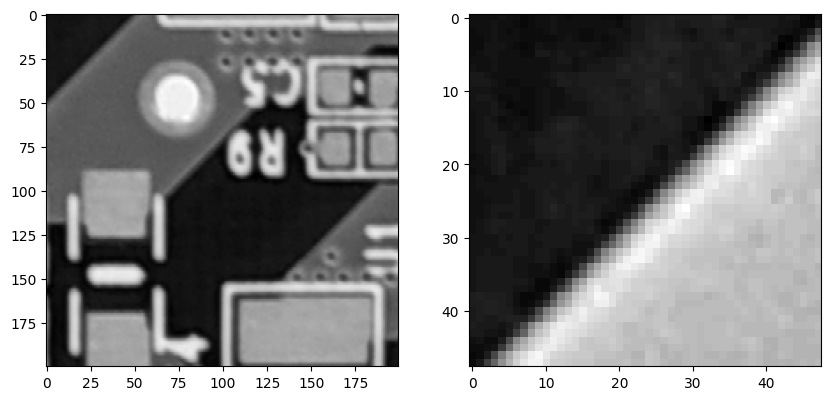

In [12]:
t1 = time.time()
computed_homographies = drizzle_py.register_images(LR1, LRs, 'ecc')
SR_drizzle = drizzle_py.super_resolve_drizzle(LRs, computed_homographies, scale=2)
# SR_drizzle = wiener_deconvolution(SR_drizzle, psf_size=3, K=0.001)
# SR_drizzle = apply_richardson_lucy(SR_drizzle, psf_size=5, iterations=30)
# SR_drizzle = clahe(SR_drizzle, clip_limit=0.5)
# SR_drizzle = unsharp_mask(SR_drizzle, radius=1.0, amount=1.2)

p_time = time.time() - t1
print(p_time)

sr_drizzle = SR_drizzle[x*2:(x+window_size)*2, y*2:(y+window_size)*2]
sr_drizzle_window = SR_drizzle[x*2:x*2+200, y*2:y*2+200]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_drizzle_window, cmap='gray')

ax2 = plt.subplot(1, 2, 2)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.imshow(sr_drizzle, cmap='gray')

plt.show()

In [13]:
MTF_at_Nyquist_sr_drizzle, MTF_50_sr_drizzle = compute_mtf_at_nyquist(sr_drizzle, filename = f'SR_DRIZZLE', scale=2, dpi=100)

if MTF_at_Nyquist_sr_drizzle is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_drizzle)
    print("MTF_50:", MTF_50_sr_drizzle * 2)

MTF evaluation finished! Elapsed time: 1.20 seconds
MTF_at_Nyquist: 40.562386382324384
MTF_50: 0.430293522112567


Registering images (measuring random shifts) using ECC...
Image 1 Shift: x=0.5250, y=-0.0205
Image 2 Shift: x=-0.0472, y=0.4826
Image 3 Shift: x=0.4709, y=0.1483
Starting IBP with 4 frames...
85.55122923851013


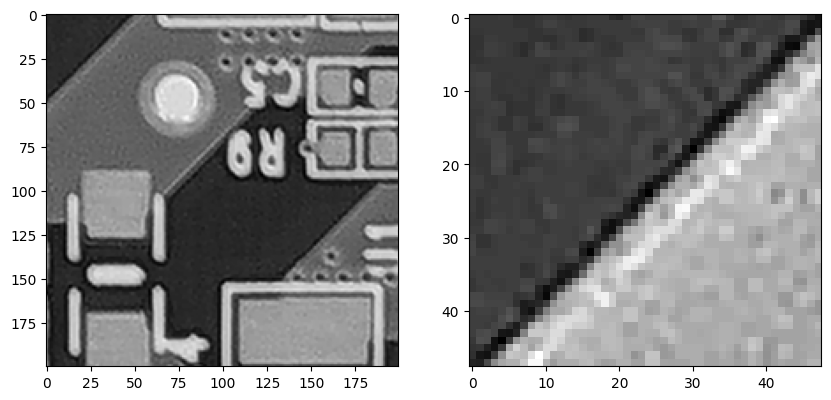

In [14]:
t1 = time.time()
shifts = ibp_py.calculate_shift(LR1, LRs, 'ecc')
SR_ibp = ibp_py.multi_frame_ibp(LRs, shifts, scale_factor=2, iterations=15, blur_sigma=1, tv_weight=0.1)
# SR_ibp = apply_richardson_lucy(SR_ibp, psf_size=5, iterations=30)
# SR_ibp = clahe(SR_ibp, clip_limit=0.5)
# SR_ibp = unsharp_mask(SR_ibp, radius=1.0, amount=1.2)

p_time = time.time() - t1
print(p_time)

sr_ibp = SR_ibp[x*2:(x+window_size)*2, y*2:(y+window_size)*2]
sr_ibp_window = SR_ibp[x*2:x*2+200, y*2:y*2+200]

plt.figure(figsize=(10,5))

ax1 = plt.subplot(1, 2, 1)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.imshow(sr_ibp_window, cmap='gray')

ax2 = plt.subplot(1, 2, 2)
ax2.tick_params(axis='both', which='major', labelsize=10)
ax2.imshow(sr_ibp, cmap='gray')

plt.show()

In [15]:
MTF_at_Nyquist_sr_ibp, MTF_50_sr_ibp = compute_mtf_at_nyquist(sr_ibp, filename = f'SR_IBP', scale=2, dpi=100)

if MTF_at_Nyquist_sr_ibp is not None:
    print("MTF_at_Nyquist:", MTF_at_Nyquist_sr_ibp)
    print("MTF_50:", MTF_50_sr_ibp * 2)

MTF evaluation finished! Elapsed time: 1.01 seconds
MTF_at_Nyquist: 79.25650369407619
MTF_50: 0.9007882739584828
